# Feature generation & feature selection

In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
from featuretools import selection

from woodwork.logical_types import Boolean, Categorical
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import make_union, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from category_encoders import OrdinalEncoder
from category_encoders.count import CountEncoder

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, mutual_info_classif
# from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt

pd.options.display.max_rows = 100

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

DataSet: https://www.kaggle.com/competitions/home-credit-default-risk/data 

или скачать из материалов урока "малый" набор данных для демонтрации учебных примеров 

In [7]:
n_rows = 10000
train = pd.read_csv('data/application_train.csv', nrows=n_rows)
test = pd.read_csv('data/application_test.csv', nrows=n_rows)
bureau = pd.read_csv('data/bureau.csv', nrows=3*n_rows)
bureau_balance = pd.read_csv('data/bureau_balance.csv', nrows=2*n_rows)
cash_balance = pd.read_csv('data/POS_CASH_balance.csv', nrows=2*n_rows)
card_balance = pd.read_csv('data/credit_card_balance.csv', nrows=2*n_rows)
prev_app = pd.read_csv('data/previous_application.csv', nrows=2*n_rows)
payments = pd.read_csv('data/installments_payments.csv', nrows=2*n_rows)

![File connection columns](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

In [8]:
train.shape

(10000, 122)

In [9]:
# Merge application data
train['Test'] = False
test['Test'] = True
test['TARGET'] = np.nan
app = pd.concat([train, test], ignore_index=True, sort=False)

Посмотрим ROC-AUC score на исходном датасете до генерации признаков.

In [10]:
# # Split data back into test + train
train_0 = app.loc[~app['Test'].values, :].copy()
test_0 = app.loc[app['Test'].values, :].copy()

# Target labels
train_y = train_0['TARGET']

# Remove test/train indicator column and target column
train_0.drop(columns=['Test', 'TARGET'], inplace=True)
test_0.drop(columns=['Test', 'TARGET'], inplace=True)
skf = StratifiedKFold(5, random_state=42, shuffle=True)

# Classification pipeline OrdinalEncoder LightGBM
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')), # для заполнения пропущенных значений
    ('classifier', LGBMClassifier())
])

# Cross-validated roc auc
scores = cross_val_score(
    lgbm_pipeline, train_0, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10284
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10288
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[Light

# Feature generation

## Featuretools

In [5]:
# Create an entity set
es = ft.EntitySet(id='applications')

In [6]:
# Add dataframe to entityset

es = es.add_dataframe(
    dataframe_name="applications", 
    dataframe=app, 
    index="SK_ID_CURR")


In [7]:
# Manually define datatypes in app dataframe
variable_types = {
    'FLAG_MOBIL': Boolean,
    'FLAG_EMP_PHONE': Boolean,
    'FLAG_WORK_PHONE': Boolean,
    'FLAG_CONT_MOBILE': Boolean,
    'FLAG_PHONE': Boolean,
    'FLAG_EMAIL': Boolean,
    'REG_REGION_NOT_LIVE_REGION': Boolean,
    'REG_REGION_NOT_WORK_REGION': Boolean,
    'LIVE_REGION_NOT_WORK_REGION': Boolean,
    'REG_CITY_NOT_LIVE_CITY':Boolean,
    'REG_CITY_NOT_WORK_CITY': Boolean,
    'LIVE_CITY_NOT_WORK_CITY': Boolean,
    'FLAG_DOCUMENT_2': Boolean,
    'FLAG_DOCUMENT_3': Boolean,
    'FLAG_DOCUMENT_4': Boolean,
    'FLAG_DOCUMENT_5': Boolean,
    'FLAG_DOCUMENT_6': Boolean,
    'FLAG_DOCUMENT_7': Boolean,
    'FLAG_DOCUMENT_8': Boolean,
    'FLAG_DOCUMENT_9': Boolean,
    'FLAG_DOCUMENT_10': Boolean,
    'FLAG_DOCUMENT_11': Boolean,
    'FLAG_DOCUMENT_12': Boolean,
    'FLAG_DOCUMENT_13': Boolean,
    'FLAG_DOCUMENT_14': Boolean,
    'FLAG_DOCUMENT_15': Boolean,
    'FLAG_DOCUMENT_16': Boolean,
    'FLAG_DOCUMENT_17': Boolean,
    'FLAG_DOCUMENT_18': Boolean,
    'FLAG_DOCUMENT_19': Boolean,
    'FLAG_DOCUMENT_20': Boolean,
    'FLAG_DOCUMENT_21': Boolean,
}

# Add dataframe to entityset, using manual datatypes
es = es.add_dataframe(
    dataframe_name="applications", 
    dataframe=app, 
    index="SK_ID_CURR",
    logical_types=variable_types)

In [8]:
dataframes = {"applications": (app, "SK_ID_CURR")}

In [9]:
# Add bureau dataframe to entityset
es = es.add_dataframe(
    dataframe_name='bureau',
    dataframe=bureau,
    index='SK_ID_BUREAU',
    logical_types={'SK_ID_CURR': Categorical}
)
dataframes['bureau'] = (bureau, 'SK_ID_BUREAU')

# Add bureau_balance dataframe to entityset
es = es.add_dataframe(
    dataframe_name='bureau_balance',
    dataframe=bureau_balance,
    index='New',
    logical_types={'SK_ID_BUREAU': Categorical}
)
dataframes['bureau_balance'] = (bureau_balance, 'New')

# Add cash_balance dataframe to entityset
es = es.add_dataframe(
    dataframe_name='cash_balance',
    dataframe=cash_balance,
    index='New',
    logical_types={
        'SK_ID_PREV': Categorical,
        'SK_ID_CURR': Categorical
    }
)
dataframes['cash_balance'] = (cash_balance, 'New')

# Add card_balance dataframe to entityset
es = es.add_dataframe(
    dataframe_name='card_balance',
    dataframe=card_balance,
    index='New',
    logical_types={
        'SK_ID_PREV': Categorical,
        'SK_ID_CURR': Categorical
    }
)
dataframes['card_balance'] = (card_balance, 'New')

# Add prev_app dataframe to entityset
es = es.add_dataframe(
    dataframe_name='prev_app',
    dataframe=prev_app,
    index='SK_ID_PREV',
    logical_types={
        'SK_ID_CURR': Categorical,
        'NFLAG_LAST_APPL_IN_DAY': Boolean
    }
)
dataframes['prev_app'] = (prev_app, 'SK_ID_PREV')

# Add payments dataframe to entityset
es = es.add_dataframe(
    dataframe_name='payments',
    dataframe=payments,
    index='New',
    logical_types={
        'SK_ID_PREV': Categorical,
        'SK_ID_CURR': Categorical
    }
)
dataframes['payments'] = (payments, 'New')

In [10]:
es

Entityset: applications
  DataFrames:
    applications [Rows: 20000, Columns: 123]
    bureau [Rows: 30000, Columns: 17]
    bureau_balance [Rows: 20000, Columns: 4]
    cash_balance [Rows: 20000, Columns: 9]
    card_balance [Rows: 20000, Columns: 24]
    prev_app [Rows: 20000, Columns: 37]
    payments [Rows: 20000, Columns: 9]
  Relationships:
    No relationships

In [11]:
# Define relationships between dataframes
relationships = [
    # parent_entity   parent_variable  child_entity      child_variable
    ('applications', 'SK_ID_CURR',   'bureau',         'SK_ID_CURR'),
    ('bureau',       'SK_ID_BUREAU', 'bureau_balance', 'SK_ID_BUREAU'),
    ('applications', 'SK_ID_CURR',   'prev_app',       'SK_ID_CURR'),
    ('applications', 'SK_ID_CURR',   'cash_balance',   'SK_ID_CURR'),
    ('applications', 'SK_ID_CURR',   'payments',       'SK_ID_CURR'),
    ('applications', 'SK_ID_CURR',   'card_balance',   'SK_ID_CURR')
]

# Create the relationships
for pe, pv, ce, cv in relationships:
    es = es.add_relationship(parent_dataframe_name=pe, parent_column_name=pv, child_dataframe_name=ce, child_column_name=cv)

In [12]:
es.relationships

[<Relationship: bureau.SK_ID_CURR -> applications.SK_ID_CURR>,
 <Relationship: bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU>,
 <Relationship: prev_app.SK_ID_CURR -> applications.SK_ID_CURR>,
 <Relationship: cash_balance.SK_ID_CURR -> applications.SK_ID_CURR>,
 <Relationship: payments.SK_ID_CURR -> applications.SK_ID_CURR>,
 <Relationship: card_balance.SK_ID_CURR -> applications.SK_ID_CURR>]

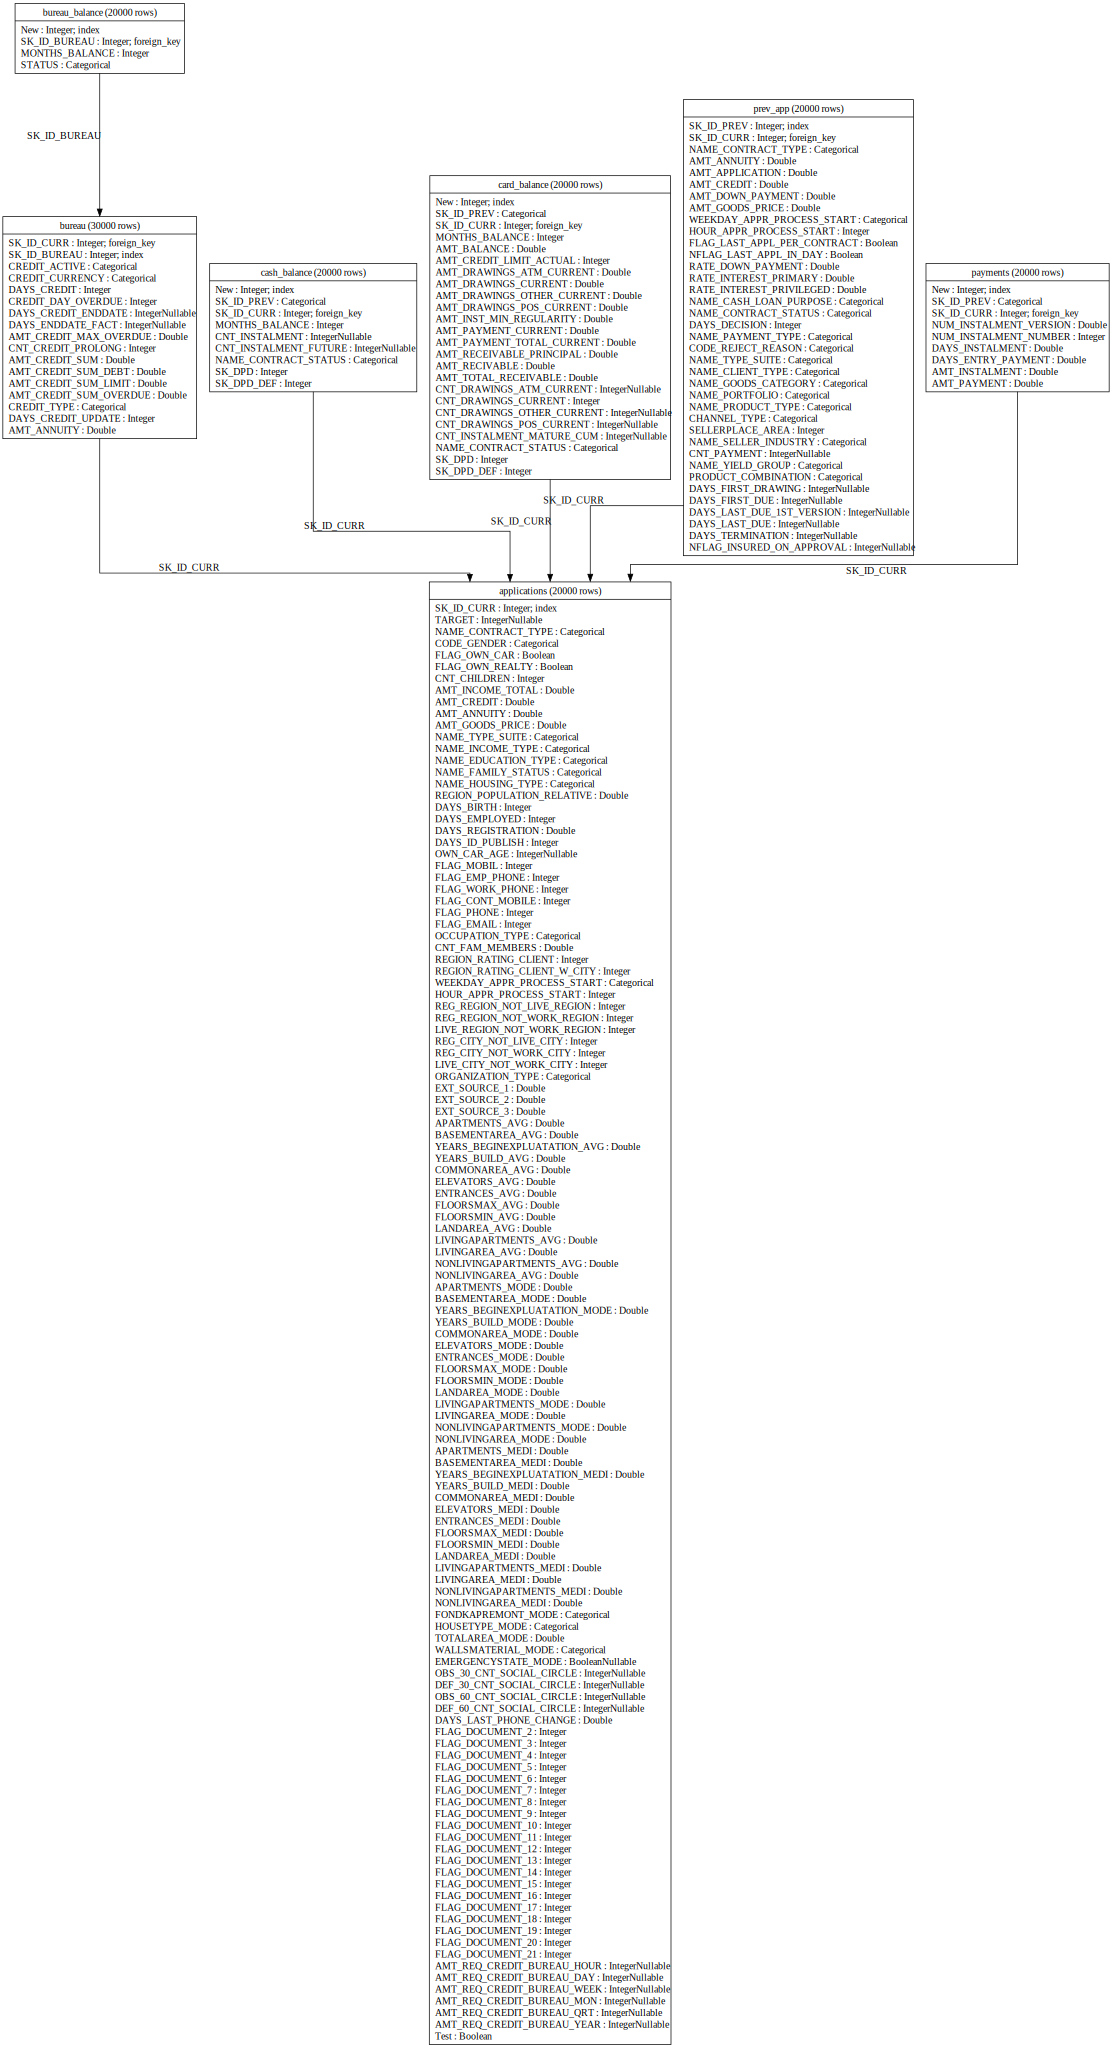

In [13]:
es.plot()

In [14]:
ft.list_primitives().head()

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,count_greater_than,aggregation,False,False,Determines the number of values greater than a...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semant...
1,count_outside_nth_std,aggregation,False,False,Determines the number of observations that lie...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semant...
2,first_last_time_delta,aggregation,False,False,Determines the time between the first and last...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = Double) (Semanti...
3,max_consecutive_false,aggregation,False,False,Determines the maximum number of consecutive F...,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = Integer) (Semant...
4,trend,aggregation,False,False,Calculates the trend of a column over time.,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",<ColumnSchema (Semantic Tags = ['numeric'])>


In [15]:
ft.list_primitives().shape[0]

203

In [16]:
ft.list_primitives()['type'].unique()

array(['aggregation', 'transform'], dtype=object)

In [17]:
ft.list_primitives().loc[ft.list_primitives()['name'] == 'sum']

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
53,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>


In [18]:
agg_primitives =  ['count', 'mean', 'num_unique']
trans_primitives = ['cum_sum']
dfs_feat, dfs_defs = ft.dfs(
    dataframes=dataframes,
    target_dataframe_name='applications',
    relationships=relationships,
    trans_primitives=trans_primitives,
    agg_primitives=agg_primitives, 
    max_features=1000,
    chunk_size=4000,
    verbose=True,                            
    max_depth=3,
    n_jobs=1
)

Built 575 features
Elapsed: 00:09 | Progress: 100%|██████████


In [19]:
es['applications'].shape[1]

123

In [20]:
dfs_feat.shape[1]

575

In [21]:
#remove_low_information_features(feature_matrix)
#remove_highly_correlated_features(feature_matrix)
#remove_highly_null_features(feature_matrix)
#remove_single_value_features(feature_matrix)

filtered = selection.remove_low_information_features(dfs_feat)

In [22]:
filtered.shape[1]

568

In [23]:
selection.remove_highly_correlated_features(dfs_feat).shape[1]

176

In [24]:
selection.remove_highly_null_features(dfs_feat).shape[1]

395

In [25]:
selection.remove_single_value_features(dfs_feat).shape[1]

561

In [26]:
# Split data back into test + train
train = dfs_feat.loc[~app['Test'].values, :].copy()
test = dfs_feat.loc[app['Test'].values, :].copy()

# Target labels
train_y = train['TARGET']

# Remove test/train indicator column and target column
train.drop(columns=['Test', 'TARGET'], inplace=True)
test.drop(columns=['Test', 'TARGET'], inplace=True)
skf = StratifiedKFold(5, random_state=42, shuffle=True)

In [27]:
%%time
# Classification pipeline OrdinalEncoder LightGBM
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')), # для заполнения пропущенных значений
    ('classifier', LGBMClassifier())
])

# Cross-validated roc auc
scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 71983
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72445
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 468
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info

In [28]:
%%time
# Classification pipeline CountEncoder LightGBM
lgbm_pipeline = Pipeline([
    ('label-encoder', CountEncoder(min_group_size=1)),
    ('imputer', SimpleImputer(strategy='median')), # для заполнения пропущенных значений
    ('classifier', CalibratedClassifierCV( # Калибровка вероятности
                        estimator=LGBMClassifier(),
                        method='isotonic'))
])

# Cross-validated roc auc
scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 496, number of negative: 5904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63736
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 496, number of negative: 5904
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65337
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[Light

## AutoFeat

This library contains the AutoFeatRegressor and AutoFeatClassifier models with a similar interface.

https://medium.com/@patil.shru/automated-feature-engineering-using-autofeat-c8550afb1536

In [29]:
from autofeat import FeatureSelector, AutoFeatRegressor

### Featureselection

In [30]:
# generate some toy data
np.random.seed(10)
x1 = np.random.rand(1000)
x2 = np.random.randn(1000)
x3 = np.random.rand(1000)
x4 = np.random.randn(1000)
x5 = np.random.rand(1000)
target = 2 + 15 * x1 + 3 / (x2 - 1 / x3) + 5 * (x2 + np.log(x1)) ** 3
X = np.vstack([x1, x2, x3, x4, x5, 1 / (x2 - 1 / x3), (x2 + np.log(x1)) ** 3]).T

In [31]:
fsel = FeatureSelector(verbose=1)
new_X = fsel.fit_transform(pd.DataFrame(X, columns=["x1", "x2", "x3", "x4", "x5", "eng6", "eng7"]), target)
# should contain ["x1", "eng6", "eng7"]
print(new_X.columns)

2023-11-10 13:01:17,736 INFO: [featsel] Feature selection run 1/5
2023-11-10 13:01:17,756 INFO: [featsel] Feature selection run 2/5
2023-11-10 13:01:17,768 INFO: [featsel] Feature selection run 3/5
2023-11-10 13:01:17,778 INFO: [featsel] Feature selection run 4/5


[featsel] Scaling data...done.


2023-11-10 13:01:17,790 INFO: [featsel] Feature selection run 5/5
2023-11-10 13:01:17,802 INFO: [featsel] 3 features after 5 feature selection runs
2023-11-10 13:01:17,803 INFO: [featsel] 3 features after correlation filtering
2023-11-10 13:01:17,806 INFO: [featsel] 3 features after noise filtering


Index(['x1', 'eng6', 'eng7'], dtype='object')


### Autofeat

### AutoFeat with 3 feateng_steps
## Final R^2: 1.0000


Text(0.5, 1.0, '3 FE steps (R^2: 1.0000; 5 new features)')

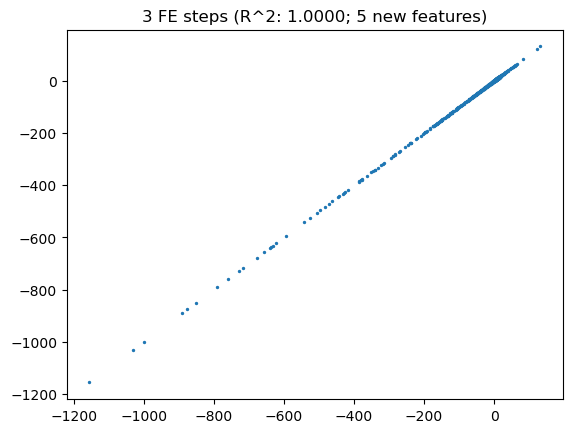

In [32]:
np.random.seed(55)
steps = 3
print("### AutoFeat with %i feateng_steps" % steps)
afreg = AutoFeatRegressor(verbose=0, feateng_steps=steps)
df = afreg.fit_transform(X, target)
r2 = afreg.score(X, target)
print("## Final R^2: %.4f" % r2)
plt.figure()
plt.scatter(afreg.predict(X), target, s=2)
plt.title("%i FE steps (R^2: %.4f; %i new features)" % (steps, r2, len(afreg.new_feat_cols_)))

## tsFresh

This part of the notebook explains how to use `tsfresh` in time series foreacasting.
Make sure you also read through the [documentation](https://tsfresh.readthedocs.io/en/latest/text/forecasting.html) to learn more on this feature.

We will use the stock price of Apple for this.
In this notebook we will only showcase how to work with a single time series at a time (one stock).
There are another notebook in the `advanced` folder (https://github.com/blue-yonder/tsfresh/tree/main/notebooks/advanced), which treats several stocks at the same time.
Basically the same - but a bit more complex when it comes to pandas multi-indexing.

In [33]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.linear_model import LinearRegression

### Download data

In [34]:
df = web.DataReader("AAPL", 'stooq')["High"]
df.head()

Date
2023-11-09    184.12
2023-11-08    183.45
2023-11-07    182.44
2023-11-06    179.43
2023-11-03    176.82
Name: High, dtype: float64

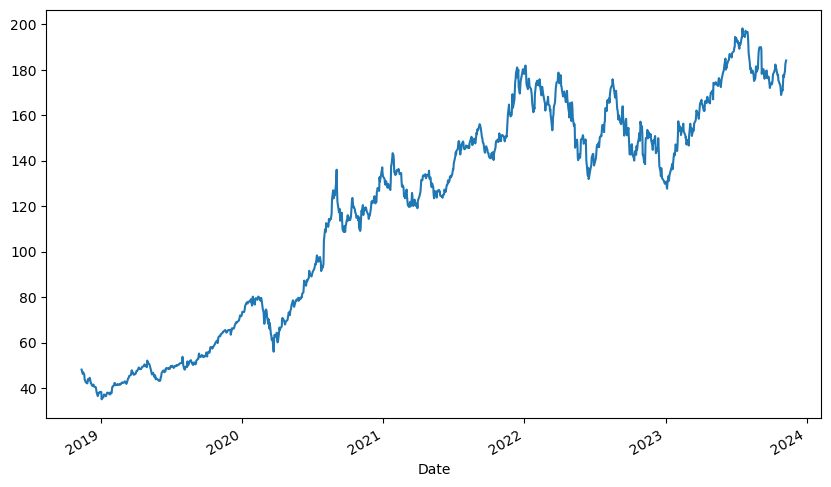

In [35]:
plt.figure(figsize=(10, 6))
df.plot(ax=plt.gca())
plt.show()

We want to make the time dependency a bit clearer and add an identifier to each of the stock values

In [36]:
df_melted = pd.DataFrame({"high": df.copy()})
df_melted["date"] = df_melted.index
df_melted["Symbols"] = "AAPL"

df_melted.head(3)

,high,date,Symbols
Date,,,
2023-11-09,184.12,2023-11-09,AAPL
2023-11-08,183.45,2023-11-08,AAPL
2023-11-07,182.44,2023-11-07,AAPL


### Create training data sample

Forecasting typically involves the following steps:
* take all data up to today
* do feature extraction (e.g. by running `extract_features`)
* run a prediction model (e.g. a regressor, see below)
* use the result as the forecast for tomorrow

In training however, we need multiple examples to train.
If we would only use the time series until today (and wait for the value of tomorrow to have a target), we would only have a single training example.
Therefore we use a trick: we replay the history.

Imagine you have a cut-out window sliding over your data.
At each time step $t$, you treat the data as it would be today. 
You extract the features with everything you know until today (which is all data until and including $t$).
The target for the features until time $t$ is the time value of time $t + 1$ (which you already know, because everything has already happened).

The process of window-sliding is implemented in the function `roll_time_series`.
Our window size will be 20 (we look at max 20 days in the past) and we disregard all windows which are shorter than 5 days.

In [37]:
df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)

Rolling: 100%|██████████| 25/25 [00:01<00:00, 16.56it/s]


The resulting dataframe now consists of these "windows" stamped out of the original dataframe.
For example all data with the `id = (AAPL, 2020-07-14 00:00:00)` comes from the original data of stock `AAPL` including the last 20 days until `2020-07-14`:

In [38]:
df_rolled[df_rolled["id"] == ("AAPL", pd.to_datetime("2020-07-14"))]

,high,date,Symbols,id
8553,85.0954,2020-06-15,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8554,86.9448,2020-06-16,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8555,87.4872,2020-06-17,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8556,87.0066,2020-06-18,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8557,87.7743,2020-06-19,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8558,88.4851,2020-06-22,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8559,91.6684,2020-06-23,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8560,90.7831,2020-06-24,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8561,89.8490,2020-06-25,AAPL,"(AAPL, 2020-07-14 00:00:00)"
8562,89.9277,2020-06-26,AAPL,"(AAPL, 2020-07-14 00:00:00)"


In [39]:
len(df_melted)

1257

we now have 1252 unique windows (identified by stock symbol and ending date). 

We "lost" 5 windows, as we required to have a minimum history of more than 5 days.

In [40]:
df_rolled["id"].nunique()

1252


![rolled window](https://encrypted-tbn3.gstatic.com/images?q=tbn:ANd9GcRszczYRUvpSF9RdDrMd8_Dx3WHE1bvs5Slowu_yP5uE4euuLIu)

### Extract Features

The rolled (windowed) data sample is now in the correct format to use it for `tsfresh`s feature extraction.
As normal, features will be extracted using all data for a given `id`, which is in our case all data of a given window and a given id (one colored box in the graph above).

If the feature extraction returns a row with the index `(AAPL, 2020-07-14 00:00:00)`, you know it has been calculated using the `AAPL` data up and including `2020-07-14` (and 20 days of history).

In [41]:
X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="date", column_value="high", 
                     impute_function=impute, show_warnings=False)

2023-11-10 13:02:07,027 WARNING: Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 25/25 [00:05<00:00,  4.43it/s]


In [42]:
X.head(3)

high__variance_larger_than_standard_deviation  \
AAPL 2018-11-19                                            0.0   
     2018-11-20                                            1.0   
     2018-11-21                                            1.0   

                 high__has_duplicate_max  high__has_duplicate_min  \
AAPL 2018-11-19                      0.0                      0.0   
     2018-11-20                      0.0                      0.0   
     2018-11-21                      0.0                      0.0   

                 high__has_duplicate  high__sum_values  high__abs_energy  \
AAPL 2018-11-19                  0.0          282.1166      13268.231248   
     2018-11-20                  0.0          325.9071      15185.839139   
     2018-11-21                  0.0          369.4024      17077.680261   

                 high__mean_abs_change  high__mean_change  \
AAPL 2018-11-19               0.732360          -0.441640   
     2018-11-20               0.981167          -0.738900   
     2018-11-21               0.883171          -0.675514   

                 high__mean_second_derivative_central  high__median  ...  \
AAPL 2018-11-19                             -0.048600       46.9877  ...   
     2018-11-20                             -0.158120       46.9269  ...   
     2018-11-21                              0.029067       46.6243  ...   

                 high__fourier_entropy__bins_5  \
AAPL 2018-11-19                       1.039721   
     2018-11-20                       1.039721   
     2018-11-21                       1.332179   

                 high__fourier_entropy__bins_10  \
AAPL 2018-11-19                        1.386294   
     2018-11-20                        1.386294   
     2018-11-21                        1.332179   

                 high__fourier_entropy__bins_100  \
AAPL 2018-11-19                         1.386294   
     2018-11-20                         1.386294   
     2018-11-21                         1.332179   

                 high__permutation_entropy__dimension_3__tau_1  \
AAPL 2018-11-19                                       1.039721   
     2018-11-20                                       0.950271   
     2018-11-21                                       0.867563   

                 high__permutation_entropy__dimension_4__tau_1  \
AAPL 2018-11-19                                       1.098612   
     2018-11-20                                       1.386294   
     2018-11-21                                       1.332179   

                 high__permutation_entropy__dimension_5__tau_1  \
AAPL 2018-11-19                                       0.693147   
     2018-11-20                                       1.098612   
     2018-11-21                                       1.386294   

                 high__permutation_entropy__dimension_6__tau_1  \
AAPL 2018-11-19                                      -0.000000   
     2018-11-20                                       0.693147   
     2018-11-21                                       1.098612   

                 high__permutation_entropy__dimension_7__tau_1  \
AAPL 2018-11-19                                       2.708050   
     2018-11-20                                      -0.000000   
     2018-11-21                                       0.693147   

                 high__query_similarity_count__query_None__threshold_0.0  \
AAPL 2018-11-19                                                0.0         
     2018-11-20                                                0.0         
     2018-11-21                                                0.0         

                 high__mean_n_absolute_max__number_of_maxima_7  
AAPL 2018-11-19                                     135.023929  
     2018-11-20                                     135.023929  
     2018-11-21                                      46.558157  

[3 rows x 783 columns]

We make the data a bit easier to work with by removing the tuple-index

In [43]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head(3)

,high__variance_larger_than_standard_deviation,high__has_duplicate_max,high__has_duplicate_min,high__has_duplicate,high__sum_values,high__abs_energy,high__mean_abs_change,high__mean_change,high__mean_second_derivative_central,high__median,...,high__fourier_entropy__bins_5,high__fourier_entropy__bins_10,high__fourier_entropy__bins_100,high__permutation_entropy__dimension_3__tau_1,high__permutation_entropy__dimension_4__tau_1,high__permutation_entropy__dimension_5__tau_1,high__permutation_entropy__dimension_6__tau_1,high__permutation_entropy__dimension_7__tau_1,high__query_similarity_count__query_None__threshold_0.0,high__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
2018-11-19,0.0,0.0,0.0,0.0,282.1166,13268.231248,0.732360,-0.441640,-0.048600,46.9877,...,1.039721,1.386294,1.386294,1.039721,1.098612,0.693147,-0.000000,2.708050,0.0,135.023929
2018-11-20,1.0,0.0,0.0,0.0,325.9071,15185.839139,0.981167,-0.738900,-0.158120,46.9269,...,1.039721,1.386294,1.386294,0.950271,1.386294,1.098612,0.693147,-0.000000,0.0,135.023929
2018-11-21,1.0,0.0,0.0,0.0,369.4024,17077.680261,0.883171,-0.675514,0.029067,46.6243,...,1.332179,1.332179,1.332179,0.867563,1.332179,1.386294,1.098612,0.693147,0.0,46.558157


In [44]:
X.loc['2020-07-14']

high__variance_larger_than_standard_deviation                 1.000000
high__has_duplicate_max                                       0.000000
high__has_duplicate_min                                       0.000000
high__has_duplicate                                           0.000000
high__sum_values                                           1909.047100
                                                              ...     
high__permutation_entropy__dimension_5__tau_1                 2.262386
high__permutation_entropy__dimension_6__tau_1                 2.566599
high__permutation_entropy__dimension_7__tau_1                 2.615631
high__query_similarity_count__query_None__threshold_0.0       0.000000
high__mean_n_absolute_max__number_of_maxima_7                94.736171
Name: 2020-07-14 00:00:00, Length: 783, dtype: float64

### Prediction

We can now use the extracted features to train a regressor.
But what will be our targets?
The target for the row `2020-07-13` is the value on the next timestep (that would be `2020-07-14` in this case).

So all we need to do is go back to our original dataframe and take the stock value of tomorrow.
This is done with `shift`:

In [45]:
y = df_melted.set_index("date").sort_index().high.shift(-1)
y["2020-07-13"], df["2020-07-14"]

(95.7619, 95.7619)

However, we need to be a bit careful here: `X` is missing the first 5 dates (as our minimum window size was 5) and `y` is missing the last date (as there is nothing to predict on today).
So lets make sure we have a consistent view on the data.

In [46]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]

We can now train normal AdaBoostRegressors to predict the next time step .
Let's split the data into a training and testing sample (but make sure to keep temporal consistency).
We take everything until 2019 as train data an the rest as test:

In [47]:
X_train = X[:"2018"]
X_test = X["2019":]

y_train = y[:"2018"]
y_test = y["2019":]

In [48]:
X_train.shape

(28, 783)

do feature selection before training

In [49]:
X_train_selected = select_features(X_train, y_train)

In [50]:
X_train_selected.shape

(28, 139)

In [51]:
ada = LinearRegression()

ada.fit(X_train_selected, y_train);

In [52]:
X_test_selected = X_test[X_train_selected.columns]

y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

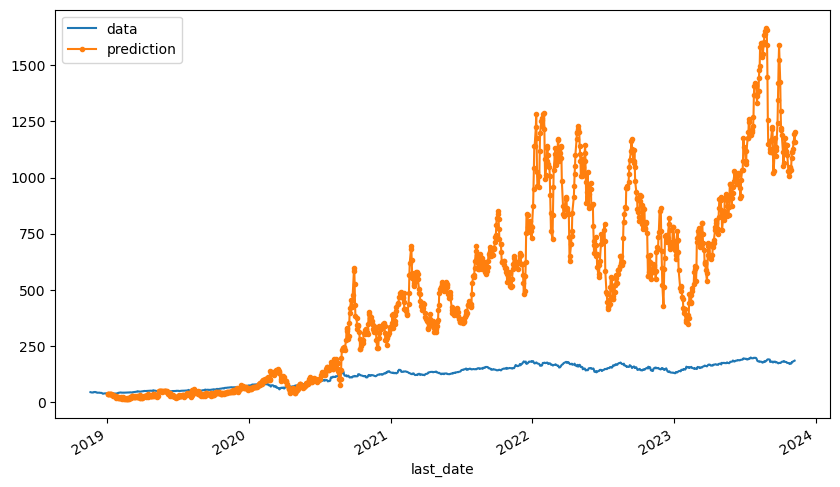

In [53]:
plt.figure(figsize=(10, 6))

y.plot(ax=plt.gca(), label='data')
y_pred.plot(ax=plt.gca(), marker=".", label='prediction')
plt.legend()
plt.show()

## tsFel

https://github.com/fraunhoferportugal/tsfel

## tsFlex

https://github.com/predict-idlab/tsflex

# Feature Selection

## Filter methods

### Constant

In [54]:
%%time
# Classification pipeline w/ LightGBM
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('constant_remover', VarianceThreshold(0.0)),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 71983
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 466
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 72445
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 468
[LightGBM] [Info] [bin

### Quasi-Constant

In [55]:
%%time
# Classification pipeline w/ LightGBM
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65283
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 415
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 65741
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 416
[LightGBM] [Info] [bin

In [56]:
quasi_constant_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99)))])

train_qc = quasi_constant_pipeline.fit_transform(train, train_y)

print(f'train features:\t{train.shape[1]}\nquasi constant:\t{train_qc.shape[1]}')


train features:	573
quasi constant:	428


### Correlation

In [57]:
%%time
class CorrSelector:
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        corr = np.absolute(np.corrcoef(X, rowvar=False))
        upper = corr*np.triu(np.ones(corr.shape), k=1).astype(bool)
        self.to_drop = [column for column in range(upper.shape[1]) if any(upper[:,column] >= self.threshold)]
        return self
    
    def transform(self, X):
        return np.delete(X, self.to_drop, axis=1)
    
    
lgbm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.99)),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train_qc, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19074
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19460
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 199
[LightGBM] [Info] [bin

In [58]:
correlated_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    ('correlated_remover', CorrSelector(.95)),])

train_cor = correlated_pipeline.fit_transform(train, train_y)

In [59]:
print(f'train features:\t\t{train.shape[1]}\nquasi constant:\t\t{train_qc.shape[1]}\ncorrelated pipeline:\t{train_cor.shape[1]}')

train features:		573
quasi constant:		428
correlated pipeline:	162


### Mutual Information

In [62]:
%%time
# Взаимная Информация
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    ('mutual_info_remover', SelectPercentile(mutual_info_classif, percentile=95)),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61118
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 394
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61629
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 394
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[Light

In [65]:
mutual_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    ('mutual_info_remover', SelectPercentile(mutual_info_classif, percentile=95))
])

train_mutual = mutual_pipeline.fit_transform(train, train_y)

print(f'train features:\t\t{train.shape[1]}\nquasi constant:\t\t{train_qc.shape[1]}\ncorrelated pipeline:\t{train_cor.shape[1]}\nmutual pipeline:\t{train_mutual.shape[1]}')

train features:		573
quasi constant:		428
correlated pipeline:	162
mutual pipeline:	406


## Embeded Methods

### LinearSVC

In [66]:
%%time
# Классификация линейных опорных векторов (передается в Pipeline с помощью SelectFromModel - реализацию feature_selection в sklearn)
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29812
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 295
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30799
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 283
[LightGBM] [Info] [bin

In [67]:
lsvc_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1",dual=False)))
])

train_lsvc = lsvc_pipeline.fit_transform(train, train_y)

print(f'train features:\t\t{train.shape[1]}\nquasi constant:\t\t{train_qc.shape[1]}\ncorrelated pipeline:\t{train_cor.shape[1]}\nmutual pipeline:\t{train_mutual.shape[1]}\nlsvc pipeline:\t\t{train_lsvc.shape[1]}')

train features:		573
quasi constant:		428
correlated pipeline:	162
mutual pipeline:	406
lsvc pipeline:		352


### LogisticRegression

In [68]:
%%time
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
    ('feature_selection', SelectFromModel(LogisticRegression(penalty="l1",solver='liblinear'))),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19841
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19715
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 215
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[Light

### ExtraTreesClassifier

In [69]:
%%time
lgbm_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
    ('feature_selection', SelectFromModel(ExtraTreesClassifier(n_estimators=50))),
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35495
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 204
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33545
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 196
[LightGBM] [Info] [bin

In [70]:
quasi_constant_pipeline = Pipeline([
    ('label-encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='median')),
    ('quasi_constant_remover', VarianceThreshold(.99 * (1 - .99))),
    ('scaler', StandardScaler()),

])

train_f = quasi_constant_pipeline.fit_transform(train, train_y)

## Wrapper Methods

### SequentialFeatureSelector

In [71]:
%%time
sfs = SequentialFeatureSelector(
    RandomForestClassifier(), 
    k_features='best', 
    forward=False, 
    floating=False,
    scoring='roc_auc',
    cv=None,
    verbose=1,
    n_jobs=-1
)

sfs = sfs.fit(train_f[:100], train_y[:100].values)

print(len(sfs.k_feature_idx_))

# print the final prediction score.
print(sfs.k_score_)

# transform to the newly selected features.
train_f_sfs = sfs.transform(train_f)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 428 out of 428 | elapsed:    4.2s finished
Features: 427/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 408 out of 427 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 427 out of 427 | elapsed:    3.0s finished
Features: 426/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 426 out of 426 | elapsed:    2.8s finished
Features: 425/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      

421
1.0000000000000002
CPU times: user 10min 5s, sys: 40.8 s, total: 10min 46s
Wall time: 12min 1s


In [72]:
train_f_sfs = sfs.transform(train_f)

In [73]:
%%time
lgbm_pipeline = Pipeline([
    ('classifier', LGBMClassifier())
])

scores = cross_val_score(
    lgbm_pipeline, train_f_sfs, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 46724
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 409
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47134
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 410
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[Light

In [74]:
train_f_sfs.shape[1]

421

### RFECV

In [75]:
%%time
# Рекурсивное исключение функций с перекрестной проверкой 


svc = LogisticRegression(penalty="l1",solver='liblinear')

rfecv = RFECV(estimator=svc, step=1, cv=None, min_features_to_select=200, scoring='roc_auc', verbose=1)
rfecv.fit(train_f[:1000], train_y[:1000])

Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
F

RFECV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
      min_features_to_select=200, scoring='roc_auc', verbose=1)

In [76]:
%%time
lgbm_pipeline = Pipeline([
    ('classifier', LGBMClassifier())
])

train_f_rfecv = rfecv.transform(train_f)


scores = cross_val_score(
    lgbm_pipeline, train_f_rfecv, train_y, 
    cv=skf, scoring='roc_auc'
)
print('Cross-validated ROC_AUC: %0.3f +/- %0.3f' % (scores.mean(), scores.std()))

[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29305
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 294
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077500 -> initscore=-2.476809
[LightGBM] [Info] Start training from score -2.476809
[LightGBM] [Info] Number of positive: 620, number of negative: 7380
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29597
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 294
[LightGBM] [Info] [bin

In [77]:
train_f_rfecv.shape[1]

304

# <div class="alert alert-warning">Summary</div>

<div class="alert alert-info">
Исходный датасет ДО генерации дополнительных признаков имел такой же score как и лучшая модель после генерации и отбора признаков.</br>


__Почему:__ В данном случае не удачно выбрали примитивы для генерации признаков. Более внимательная работа с примитивами ___возможно___ даст лучший результат.

К автоматической генерации признаков нужно относится очень внимательно, ___иногда___ это может помоч, но не всегда. Иногда это время окажется потраченным в пустую.
</div>